In [4]:
import argparse
import os
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs('images', exist_ok = True)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [12]:
from torchsummary import summary

# 테스트용 네트워크를 정의합니다.
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(64)

    def forward(self, x):
        return self.bn(self.conv(x))

# 모델 생성 및 가중치 초기화 전 출력
model = SimpleNet()
print(model.conv.weight.shape)
print("Before initialization:")
print("Conv weights:", model.conv.weight.data[0][0]) # 첫번째 채널의 첫번째 커널의 가중치를 출력
print("BatchNorm weights:", model.bn.weight.data)
print("BatchNorm bias:", model.bn.bias.data)

# 가중치 초기화
model.apply(weights_init_normal)

print("\nAfter initialization:")
print("Conv weights:", model.conv.weight.data[0][0])
print("BatchNorm weights:", model.bn.weight.data)
print("BatchNorm bias:", model.bn.bias.data)


torch.Size([64, 3, 3, 3])
Before initialization:
Conv weights: tensor([[-0.0375,  0.0700,  0.1738],
        [-0.0042,  0.0473,  0.1647],
        [-0.1405,  0.0296,  0.0409]])
BatchNorm weights: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
BatchNorm bias: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

After initialization:
Conv weights: tensor([[ 0.0002,  0.0110, -0.0034],
        [ 0.0140,  0.0021, -0.0510],
        [ 0.0017, -0.0057,  0.0047]])
BatchNorm weights: tensor([0.9868, 1.0218, 1.0130, 1.0078, 0.9898, 0.98

In [14]:
class Option():
    n_epochs = 200
    batch_size = 64
    lr = 0.0002
    b1 = 0.5
    b2 = 0.999
    n_cpu = 8
    latent_dim = 100
    img_size = 32
    channels = 1
    sample_interval = 500

opt = Option()
cuda = True if torch.cuda.is_available() else False

In [15]:
import torch
import torch.nn as nn

# 1x1x2x2 크기의 입력 (Batch size=1, Channels=1, Height=2, Width=2)
input_tensor = torch.tensor([[[[1, 2], [3, 4]]]], dtype=torch.float32)

# nn.Upsample 레이어 생성
upsample = nn.Upsample(scale_factor=2, mode='nearest')

# 업샘플링 수행
output_tensor = upsample(input_tensor)
print(output_tensor.shape)

torch.Size([1, 1, 4, 4])


In [25]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 64 // 4 = 16
        self.init_size = opt.img_size // 4

        # 100, 128 * 16 * 16
        self.ll = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128, 128, 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128, 64, 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(64, opt.channels, 3, stride = 1, padding = 1),
            nn.Tanh()
        )

    def forward(self, z):
        #print(z.shape)
        out = self.ll(z)
        #print(out.shape)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        #print(out.shape)
        img = self.conv_blocks(out)
        #print(img.shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn = True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace =True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            # Discriminator나 Classifier의 첫 번째 층에 배치 정규화를 적용하지 않는 것이 좋은 결과를 가져올 수 있음이 관찰되었습니다.
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # stride가 2이기 때문에 conv2d를 한번 거칠 때마다 이미지 사이즈가 2배씩 작아질 것이다. 총 4번 conv2d를 통과하니 2^4가 된다.
        ds_size = opt.img_size // 2 ** 4

        # ds_size ** 2 = 가로 x 세로
        self.adv_layer = nn.Linear(128 * ds_size ** 2, 1)

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
model = Generator()
z = Variable(Tensor(np.random.normal(0, 1, (32, opt.latent_dim))))
model(z)

In [27]:
adversarial_loss = torch.nn.MSELoss()

generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


[Epoch 0/200] [Batch 0/938] [D loss: 0.536344] [G loss: 1.071348]


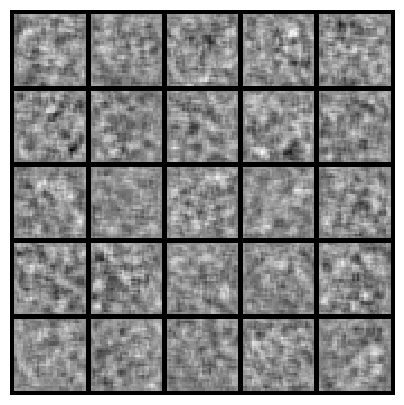

KeyboardInterrupt: ignored

In [37]:
for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        valid = Tensor(imgs.shape[0], 1).fill_(1.0).detach()
        fake = Tensor(imgs.shape[0], 1).fill_(0.0).detach()

        # 64, 1, 32, 32
        real_imgs = imgs.type(Tensor)

        optimizer_G.zero_grad()

        # 64, 100
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim)))

        # 64, 1, 32, 32
        gen_imgs = generator(z)

        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()


        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

            plt.figure(figsize = (5,5))
            img1 = cv2.imread("images/%d.png" %batches_done)
            plt.imshow(img1, interpolation='nearest')
            plt.axis('off')
            plt.show()